<a href="https://colab.research.google.com/github/kulaginv/cvr_course/blob/main/notebooks/localization_hw8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Локализация. Упражнения

В этих упражнениях вам предлагается реализовать простые алгоритмы локализации роботов. На лекции, помимо фильтра частиц, были упомянуты методы триангуляции и альфа-бета фильтр. Давайте их реализуем: обе реализации должны быть сделаны в виде класса, у которого должен быть метод update. Метод update принимает на вход измеренения с камеры о положении ориентиров в сосбтвенной системе координат робота.

В качестве ориентиров будем использовать координаты стоек ворот. Для удобства будем пользоваться упрощенным вариантом, при котором ворота разных цветов. В словаре храняться положения стоек в глобальной системе координат (точка (0, 0) нахождится в центре поля)

In [1]:
landmarks = {
    "blue_posts": [
        [ -4.5, -1.0], [ -4.5, 1.0]
    ],
    "yellow_posts":[
        [ 4.5, -1.0], [ 4.5, 1.0]
    ]
}

Пример данных, которые могут поступать в модуль на одном шаге всей системы. Данные во втором словаре – это данные одометрии с собвственной информацией робота о перемещении за один шаг системы. Для проверки работы придумайте и запишите набор данных с такой же структурой. 

In [146]:
#observations = {"yellow_posts":[[4.45, -0.99],[4.49, 1.09]], "blue_posts":[]}
#shift = {'shift_x':0.0, 'shift_y':0.01, 'shift_angle':-0.4} 
observations = {"yellow_posts":[[3.45, -0.99],[3.49, 1.09]], "blue_posts":[]}
shift = {'shift_x':1.0, 'shift_y':0.01, 'shift_angle':-0.27} 

### 1) Реализовать локализацию триангуляцией (3 балл)
    

In [4]:
class Robot:
  def __init__(self,x=0,y=0,ang=0):
    self.x = x
    self.y = y
    self.ang = ang

In [57]:
from math import sqrt
class localization_triangulation:
    
    #put your code here
    def __init__(self,robot,landmarks):
      self.robot = robot
      self.landmarks = landmarks
    
    def get_points_of_intersection(self,x10, y10, r1 , x20, y20, r2):
      d = sqrt((x10-x20)**2 + (y10-y20)**2)
      if d > r1+r2 : return 0;
      a = (r1*r1 - r2*r2 + d*d ) / (2*d)
      h = sqrt(r1**2 - a**2)
      x0 = x10 + a*(x20 - x10)/d;
      y0 = y10 + a*(y20 - y10)/d;
      x1= x0 + h*(y20 - y10)/d;
      y1= y0 - h*(x20 - x10)/d;
      print('First intersection : ', x1,y1)
      if a == r1 : return [x1,y1]
      x2 = x0 - h*(y20 - y10)/d;
      y2 = y0 + h*(x20 - x10)/d;
      print('Second intersection : ', x2,y2)
      return [x1,y1,x2,y2]
    
    def update(self,observations):
      if observations['yellow_posts']:
        dxl = observations['yellow_posts'][0][0]
        dyl = observations['yellow_posts'][0][1]
        r1 = sqrt(dxl**2+dyl**2)
        dxR = observations['yellow_posts'][1][0]
        dyR = observations['yellow_posts'][1][1]
        r2 = sqrt(dxR**2+dyR**2)
        x10 = self.landmarks['yellow_posts'][0][0]
        y10 = self.landmarks['yellow_posts'][0][1]
        x20 = self.landmarks['yellow_posts'][1][0]
        y20 = self.landmarks['yellow_posts'][1][1]
      else :
        dxl = observations['blue_posts'][0][0]
        dyl = observations['blue_posts'][0][1]
        r1 = sqrt(dxl**2+dyl**2)
        dxR = observations['blue_posts'][1][0]
        dyR = observations['blue_posts'][1][1]
        r2 = sqrt(dxR**2+dyR**2)
        x10 = self.landmarks['blue_posts'][0][0]
        y10 = self.landmarks['blue_posts'][0][1]
        x20 = self.landmarks['blue_posts'][1][0]
        y20 = self.landmarks['blue_posts'][1][1]
      inter = self.get_points_of_intersection(x10, y10, r1 , x20, y20, r2)
      return inter[2], inter[3]

In [147]:
triang = localization_triangulation(Robot(0.0,0.0,0.0), landmarks)

In [148]:
triang.update(observations)

First intersection :  7.980037649221629 -0.1214000000000004
Second intersection :  1.0199623507783713 -0.1214000000000004


(1.0199623507783713, -0.1214000000000004)

### 2) Дополнить предыдущий пункт до альфа-бета фильтра (5 балла)

In [128]:
class localization_alphabeta:

    def __init__(self,robot,landmarks):
      self.robot = robot
      self.landmarks = landmarks

    def update(self,observations,shift):
        alpha = 0.85
        beta = 0.15
        x_init = self.robot.x
        y_init = self.robot.y
        x_od = (x_init + shift['shift_x'])*alpha
        if shift['shift_angle']<0: y_od = (y_init - shift['shift_y'])*alpha
        else: y_od = (y_init + shift['shift_y'])*alpha
        triang = localization_triangulation((x_od,y_od,self.robot.ang), self.landmarks)
        vision = triang.update(observations)
        newx = x_od+vision[0]*beta
        newy = y_od+vision[1]*beta

        return newx, newy, shift['shift_angle']

In [149]:
loc = localization_alphabeta(Robot(0.0,0.0,0.0), landmarks)

In [150]:
new_loc = loc.update(observations,shift)
new_loc

First intersection :  7.980037649221629 -0.1214000000000004
Second intersection :  1.0199623507783713 -0.1214000000000004


(1.0029943526167557, -0.02671000000000006, -0.27)

### 3) *Дополнительно* Добавьте визуализацию вида сверху  (2 балла)

Например на OpenCV или Matplotlib, например так как было в семинаре, чтобы можно было удобно посмотреть на работу модуля.


In [82]:
parfield = {
    'circles': [
              [0.0,0.0,1.0]
    ],
    'lines': [
              [[-3.0,3.0],[0.0,0.0]]
    ],
    'points': [
              [0.0,0.0]
    ],
    'main_rectangle': [
              [6.0,9.0]
    ],
    'rectangles': [
              [[-1,-4.5],2,1],[[-1,3.5],2,1]
    ]
}

In [89]:
class Field:
  def __init__(self, field_param):
    self.field = field_param
    self.w_width = field_param['main_rectangle'][0][0]
    self.w_lenght = field_param['main_rectangle'][0][1]

In [139]:
import matplotlib.pylab as plt
import math
field = Field(parfield)
def visualistion(robot, apr=True, factor=7):
  plt.figure("Robot coordinates", figsize=(field.w_width, field.w_lenght))
  plt.title('Aplha-Beta filtre')

  grid = [-field.w_width/2.0, field.w_width/2.0, -field.w_lenght/2.0, field.w_lenght/2.0]
  ax = plt.axis(grid)

  for el in field.field:
    if el == 'circles':
      for circle in field.field['circles']:
        plot_circle = plt.Circle((circle[0], circle[1]), circle[2], linewidth=2, fill=False, edgecolor='#994c00')
        plt.gca().add_patch(plot_circle)
    if el == 'lines':
      for line in field.field['lines']:
        plot_line = plt.Line2D(line[0], line[1], linewidth=2, linestyle='-', color='#330000')
        plt.gca().add_line(plot_line)
    if el == 'rectangles':
      for rectangle in field.field['rectangles']:
        rect = plt.Rectangle(rectangle[0], rectangle[1], rectangle[2], linewidth=2, linestyle='-', fill=False)
        plt.gca().add_patch(rect)

    if apr != False:
      circle = plt.Circle((robot.y, robot.x), 1./factor, facecolor='#FF66E9', edgecolor='#FF66E9')
      plt.gca().add_patch(circle)

      arrow = plt.Arrow(robot.y, robot.x, 3*math.sin(robot.ang)/factor, 3*math.cos(robot.ang)/factor, width=1/factor)
      plt.gca().add_patch(arrow)


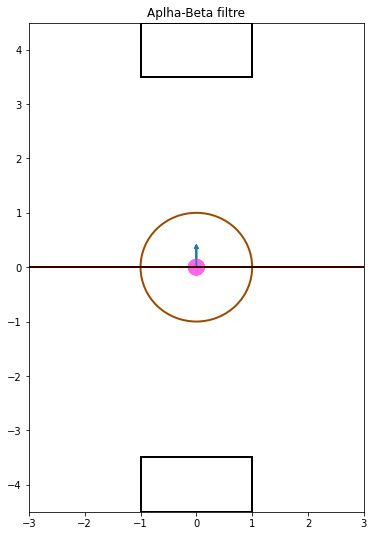

In [151]:
visualistion(Robot(0.0,0.0,0.0))

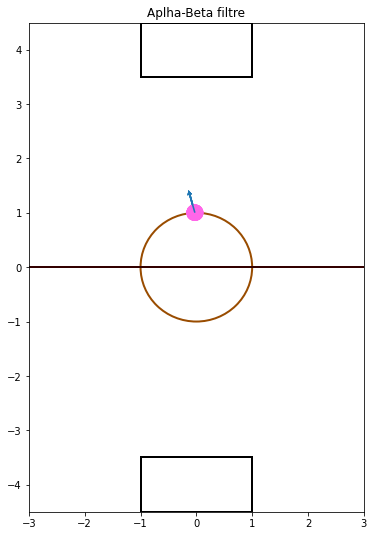

In [152]:
visualistion(Robot(new_loc[0],new_loc[1],new_loc[2]))